In [1]:
import sympy as sp
import minterpy as mp
import numpy as np
from minterpy.pointcloud_utils import *

from mpl_toolkits import mplot3d
%matplotlib inline

from mpl_toolkits.mplot3d import axes3d

import torch
import torchvision
from torchvision import transforms, datasets

import random
import numpy as np
import matplotlib.pyplot as plt

import os
from operator import itemgetter

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import ot

from sklearn.neighbors import NearestNeighbors

import ripser
import persim
from persim import plot_diagrams

from operator import itemgetter


#do pip installs as follows to use vedo for plotting point clouds
#pip install vedo
#pip install ipyvtklink

import numpy as np
from vedo import *

import matplotlib.pyplot
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def give_centeroid(arr):
    length = arr.shape[0]
    sum_x = np.sum(arr[:, 0])
    sum_y = np.sum(arr[:, 1])
    sum_z = np.sum(arr[:, 2])
    return np.array([[sum_x/length, sum_y/length, sum_z/length]])

In [3]:
def give_next_neighbours_barycenter_indices(batch_x, input_barycenter, remaining_indices, sweep_radsius):
    
  #sweep_radsius = 0.2
  #num_neighbours = int(batch_x.shape[0] / no_of_barycenetrs_required)
    
  wasserDistance = []
  distance_cum_index = np.array([])

  for j in remaining_indices:
    
    wassDistance = dist = np.linalg.norm(batch_x[j]-input_barycenter)

    distance_cum_index = np.concatenate((distance_cum_index, np.array([wassDistance, j])), axis = 0)
   
  distance_cum_index = distance_cum_index.reshape(int(distance_cum_index.shape[0]/2), 2)
  distance_cum_index = sorted(distance_cum_index, key=itemgetter(0))
  
  distance_cum_index = np.array(distance_cum_index)
  
  only_distances = distance_cum_index[:,0]
  #print(only_distances)
  where_is_it = np.where( only_distances < sweep_radsius ) 
  #print('where_is_it', where_is_it)  
  #print('where_is_it[0][-1]', where_is_it[0][-1])
  num_neighbours = where_is_it[0][-1] +1
  #print('where_is_it[0]', where_is_it[0])
  #print('where_is_it[0][-1]', where_is_it[0][-1])
  #print('num_neighbours',num_neighbours)
  #break
  #print('distance_cum_index',distance_cum_index[:,1])
  remaining_indices = distance_cum_index[:,1]

  remaining_indices = remaining_indices.astype(int)
  
    
  A = np.array([])
  for i in range(num_neighbours):
    if(i >= distance_cum_index[:,1].shape[0]):
        break
    A = np.concatenate((A, batch_x[int(distance_cum_index[:,1][i])]), axis = 0 )
  
  A = A.reshape(int(A.shape[0]/3) , 3)
  
  #print("The shape of A is ")
  #print(A.shape)
  next_barycenter = give_centeroid(A) 
  
  next_barycenter = np.array(next_barycenter)
  #print(next_barycenter.shape)
  next_barycenter = next_barycenter.reshape(next_barycenter.shape[0]* next_barycenter.shape[1])
  #print(next_barycenter)  
  return A, next_barycenter, remaining_indices,num_neighbours


In [4]:
def get_convergent_barycenters(point_cloud, initial_pt,sweep_radsius):   
    
    #no_neighbours = int(point_cloud.shape[0] / no_of_barycenetrs_required)
    #initiating no of neighbours
    #no_neighbours = 5
    
    #num_neighbours = int(batch_x.shape[0] / no_of_barycenetrs_required)

    
    bary = initial_pt
    rem_indices = np.array(range(0,point_cloud.shape[0]))
    #print(rem_indices)
    #print("Size of batch : ", point_cloud.shape[0])
    sampled_barycenters = np.array([])
    sampled_barycenters = torch.tensor(sampled_barycenters)
    covered_indices = np.array([])

    for i in range(int(point_cloud.shape[0])):

        if(len(rem_indices) == 2):
            #print("END")
            break

        #print("Iteration number : ", i+1)
        #print("Input barycenter : ")


        old_bary = bary


        #print('rem_indices before', rem_indices)
        neighbours, bary, rem_indices, no_neighbours = give_next_neighbours_barycenter_indices(point_cloud, bary, rem_indices, sweep_radsius)
        #print('no_neighbours', no_neighbours)
        #break
        wassDistance = np.linalg.norm(old_bary - bary)  

        covered_indices = np.concatenate((covered_indices, rem_indices[:4] ) ,axis = 0)


        #print("Tracking distance between new barycenter and previous barycenter : ",wassDistance )
        if(wassDistance < 0.000001):

            unique_covered_indices = np.unique(covered_indices, axis=0)
            sampled_barycenters = torch.cat((sampled_barycenters, torch.tensor(bary)), 0)

            s1 = set(rem_indices)
            s2 = set(unique_covered_indices)
            rem_set = s1 - s2
            rem_inds = list(rem_set)
            #rem_indices = rem_set
            rem_indices = rem_indices[no_neighbours:]

            #print("Sampled barycenters are")
            #print(sampled_barycenters)
            #no_neighbours = 5
            #print('rem_indices',rem_indices)
            #print("len(rem_indices)",len(rem_indices))
            if(len(rem_indices) ==0):
                break
            bary = point_cloud[rem_indices[0]]
    sampled_barycenters = sampled_barycenters.reshape(int((sampled_barycenters.shape[0]/3)),3)
    
    return sampled_barycenters

In [5]:
def _compute_distance_matrix(x, p=2):
    x_flat = x.view(x.size(0), -1)

    distances = torch.norm(x_flat[:, None] - x_flat, dim=2, p=p)

    return distances

In [6]:
def get_persistence_diagram(point_cloud, maximum_dim):

    point_cloud = torch.tensor(point_cloud)

    dist_matrix = _compute_distance_matrix(point_cloud, p=2)
    diagrams = ripser.ripser(dist_matrix.cpu().detach().numpy(), distance_matrix=True, maxdim=maximum_dim)['dgms']
    return diagrams, plot_diagrams(diagrams, show=True)


# Torus in 3D

In [7]:
x, y, z = sp.symbols('x y z')


In [8]:
## Torus
R = 1.5
r = 0.7
expr_torus = (x**2 + y**2 + z**2 + R**2 - r**2)**2 - 4*R**2*(x**2 + y**2)


In [9]:
expr_torus

-9.0*x**2 - 9.0*y**2 + 3.0976*(0.568181818181818*x**2 + 0.568181818181818*y**2 + 0.568181818181818*z**2 + 1)**2

In [10]:
poly_torus = sp.Poly(expr_torus, x, y, z)

In [11]:
sp.expand(expr_torus)

1.0*x**4 + 2.0*x**2*y**2 + 2.0*x**2*z**2 - 5.48*x**2 + 1.0*y**4 + 2.0*y**2*z**2 - 5.48*y**2 + 1.0*z**4 + 3.52*z**2 + 3.0976

In [12]:
#Convert sympy polynomial to minterpy polynomial

newt_poly_torus = sympy_to_mp(poly_torus, mp.NewtonPolynomial)

# Trials on Torus : 

In [13]:
#Sample points on the zero isocontour
def points_on_torus(num_points):
    
    point_data_torus = sample_points_on_poly(num_points,        # Number of points to be sampled
                                       newt_poly_torus,  # Polynomial in Newton basis
                                       bounds=3.0, # Boundary of the Cubic domain to be sampled
                                       tol=1e-15)  # Tolerance in solution
    
    return point_data_torus

# 1. 1000 barycenters from 10000 points

In [14]:
#Sample points on the zero isocontour

point_data_torus = sample_points_on_poly(8000,        # Number of points to be sampled
                                   newt_poly_torus,  # Polynomial in Newton basis
                                   bounds=3.0, # Boundary of the Cubic domain to be sampled
                                   tol=1e-15)  # Tolerance in solution

In [15]:
point_data_torus.shape

(8000, 3)

In [16]:
cut_torus1 = point_data_torus[np.where(point_data_torus[:,0]<1.5)]

cut_torus2 = (point_data_torus[np.where(point_data_torus[:,0]>-1.5)]+np.array([1.4, 0, 0])*2)*1.1

In [17]:
x_t = point_data_torus[:,0]
y_t = point_data_torus[:,1]
z_t = point_data_torus[:,2]


plot_points = [x_t,y_t,z_t]
Points(plot_points).show(axes=1)

ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

In [18]:
x_t = cut_torus1[:,0]
y_t = cut_torus1[:,1]
z_t = cut_torus1[:,2]


plot_points = [x_t,y_t,z_t]
Points(plot_points).show(axes=1)

ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

In [19]:
x_t = cut_torus2[:,0]
y_t = cut_torus2[:,1]
z_t = cut_torus2[:,2]


plot_points = [x_t,y_t,z_t]
Points(plot_points).show(axes=1)

ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

In [20]:
joined_torus = np.concatenate((cut_torus1, cut_torus2))

In [21]:
joined_torus_lower_cut = joined_torus[np.where(joined_torus[:,1]>-1.3)]

In [22]:
x_t = joined_torus[:,0]
y_t = joined_torus[:,1]
z_t = joined_torus[:,2]


plot_points = [x_t,y_t,z_t]
Points(plot_points).show(axes=1)

ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

In [23]:
x_t = joined_torus_lower_cut[:,0]
y_t = joined_torus_lower_cut[:,1]
z_t = joined_torus_lower_cut[:,2]


plot_points = [x_t,y_t,z_t]
Points(plot_points).show(axes=1)

ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

In [24]:
stretched_upper_cut_torus = ((point_data_torus[np.where(point_data_torus[:,1]<1.5)])*np.array([2.2, 1.0 ,1.0])) + np.array([1.7, -2.8, 0])

In [25]:
x_t = stretched_upper_cut_torus[:,0]
y_t = stretched_upper_cut_torus[:,1]
z_t = stretched_upper_cut_torus[:,2]


plot_points = [x_t,y_t,z_t]
Points(plot_points).show(axes=1)

ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

In [26]:
genus3surface = np.concatenate((joined_torus_lower_cut,stretched_upper_cut_torus ))

genus3surface = genus3surface[np.where(genus3surface[:,1]<2.0)]


In [27]:
x_t = genus3surface[:,0]
y_t = genus3surface[:,1]
z_t = genus3surface[:,2]


plot_points = [x_t,y_t,z_t]
Points(plot_points).show(axes=1)

ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

In [28]:
rotator1 = np.array([[np.cos(0.3), -1*np.sin(0.3), 0],[np.sin(0.3), -1*np.cos(0.3), 0], [0, 0, 1]]) 




In [29]:

ear1b = np.matmul(point_data_torus, rotator1)# + np.array([-4, 4, 0])

ear1 = ear1b[np.where(ear1b[:,1] > -1.7) ] + np.array([-1.15, 3.7, 0])

ear1 = ear1 * 0.94

ear2b = ear1b * np.array([1, -1, 1])# + np.array([8, 8, 0]) 
ear2 = ear2b[np.where(ear2b[:,1] > -1.5)] + np.array([4, 3.5, 0]) 
#ear2 = ear1 * np.array([1, -1, 1])

In [30]:
x_t = ear1[:,0] 
y_t = ear1[:,1] 
z_t = ear1[:,2]


plot_points = [x_t,y_t,z_t]
Points(plot_points).show(axes=1)

ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

In [31]:
x_t = ear2[:,0] 
y_t = ear2[:,1] 
z_t = ear2[:,2]


plot_points = [x_t,y_t,z_t]
Points(plot_points).show(axes=1)

ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

In [32]:
x_t = ear2b[:,0] 
y_t = ear2b[:,1] 
z_t = ear2b[:,2]


plot_points = [x_t,y_t,z_t]
Points(plot_points).show(axes=1)

ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

In [33]:
bunny = np.concatenate((genus3surface,ear1, ear2 ))

In [58]:
x_t = bunny[:,0] 
y_t = bunny[:,1] 
z_t = bunny[:,2]


plot_points = [x_t,y_t,z_t]
Points(plot_points).show(axes=1)

ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

In [35]:
bunny.shape

(31444, 3)

In [36]:
rand_sampled_bunny = bunny[np.random.randint(0,31444, 614)]

In [45]:
torch.save( bunny, '/media/chethan/New Volume/Thesis/circle_torus_autoencoder_experiments/val3dgenus5.pt')

# demo of barycenter convergence on a torus


In [60]:
bunny_bary = get_convergent_barycenters(bunny, bunny[0],0.23)

In [61]:
bunny_bary.shape

torch.Size([1737, 3])

In [62]:
#bunny_bary = np.concatenate((bunny_bary, bunny_bary[0].reshape(1,3)*0.01, bunny_bary[10].reshape(1,3)*0.01 ))

In [63]:
bunny_bary = bunny_bary[np.random.randint(0,bunny_bary.shape[0], bunny_bary.shape[0])]



In [64]:
#bunny_bary = torch.load('/media/chethan/New Volume/Thesis/circle_torus_autoencoder_experiments/min3d1212ptsBunny.pt')

In [65]:
# plotting the sampled barycenters

x_stb = bunny_bary[:,0]#.cpu().detach().numpy()

y_stb = bunny_bary[:,1]#.cpu().detach().numpy()

z_stb = bunny_bary[:,2]#.cpu().detach().numpy()



plot_points = [x_stb,y_stb,z_stb]
Points(plot_points).show(axes=1)

ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

In [66]:
torch.save( bunny_bary, '/media/chethan/New Volume/Thesis/circle_torus_autoencoder_experiments/min3d1737ptsBunny.pt')

In [43]:
# plotting the sampled barycenters

x_stb = rand_sampled_bunny[:,0]#.cpu().detach().numpy()

y_stb = rand_sampled_bunny[:,1]#.cpu().detach().numpy()

z_stb = rand_sampled_bunny[:,2]#.cpu().detach().numpy()



plot_points = [x_stb,y_stb,z_stb]
Points(plot_points).show(axes=1)

ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

# Trajectory of barycenter smpling


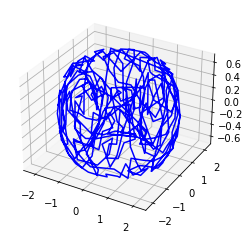

In [24]:

fig = matplotlib.pyplot.figure()
ax  = fig.add_subplot(111, projection = '3d')

X = torus_bary[:,0]
Y = torus_bary[:,1]
Z = torus_bary[:,2]
ax.plot(X, Y, Z, color = 'b')
plt.show()

# Persistent homology of sampled barycenters

In [44]:
import matplotlib
matplotlib.rcdefaults()
from persim import plot_diagrams

/tmp/ipykernel_42169/1703124144.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  point_cloud = torch.tensor(point_cloud)


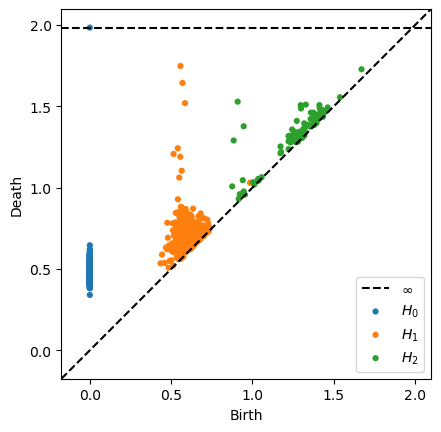

In [45]:
torus_PH_arrays,PH_diagram_barycenters_torus = get_persistence_diagram(bunny_bary,2)

In [59]:
PH_diagram_barycenters_torus

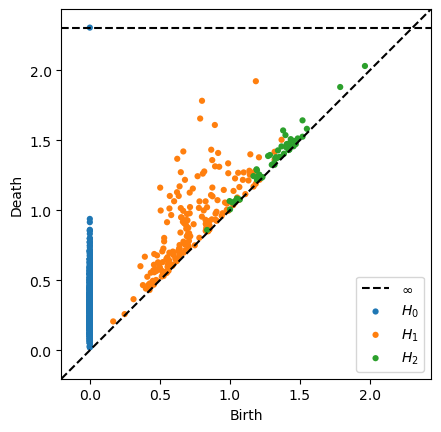

In [46]:
torus_PH_arrays,PH_diagram_barycenters_torus = get_persistence_diagram(rand_sampled_bunny,2)

# Persistent homology of original points

In [ ]:
#torus_PH_arrays_ori,PH_diagram_ori_torus = get_persistence_diagram(point_data_torus,2)

# observation

The persistent homology signatures are very similar but the sacles at which births and deaths occur are different. The birth and death values in PH of barycenters are higher than their counterparts in original points cloud. The same has to be eperimented on image datasets

# Sphere

In [15]:
expr = x**2 + y**2 + z**2 - 1
poly = sp.Poly(expr, x, y, z)

In [16]:
expr

x**2 + y**2 + z**2 - 1

In [17]:
    # convert sympy polynomial to minyterpy polynomial
newt_poly = sympy_to_mp(poly, mp.NewtonPolynomial)

In [18]:
#sample points
point_data = sample_points_on_poly(10000,        # Number of points to be sampled
                                   newt_poly,  # Polynomial in Newton basis
                                   bounds=1, # Boundary of the Cubic domain to be sampled
                                   tol=1e-15)  # Tolerance in solution

In [19]:
point_data.shape

(10000, 3)

In [20]:

x_so = point_data[:,0]

y_so = point_data[:,1]

z_so = point_data[:,2]


plot_points = [x_so,y_so,z_so]
Points(plot_points).show(axes=1)

ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

In [24]:
sphere_bary = get_convergent_barycenters(point_data, point_data[0], 0.25)

In [25]:
sphere_bary.shape

torch.Size([120, 3])

# Plotting sphere barycenters

In [34]:

x_spb = sphere_bary[:,0]

y_spb = sphere_bary[:,1]

z_spb = sphere_bary[:,2]


plot_points = [x_spb,y_spb,z_spb]
Points(plot_points).show(axes=1)

ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

/tmp/ipykernel_11341/1703124144.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  point_cloud = torch.tensor(point_cloud)


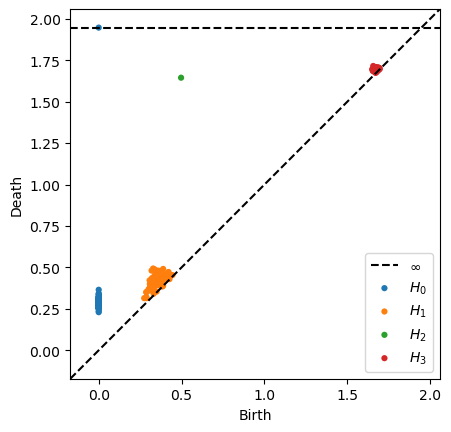

In [20]:
sphere_PH_arrays,PH_diagram_barycenters_sphere = get_persistence_diagram(sphere_bary,3)

# Trajectory of barycenter smpling on sphere


In [ ]:

fig = matplotlib.pyplot.figure()
ax  = fig.add_subplot(111, projection = '3d')

X = sphere_bary[:,0]
Y = sphere_bary[:,1]
Z = sphere_bary[:,2]
ax.plot(X, Y, Z, color = 'b')
plt.show()

In [ ]:
#original point cloud sphere persistence diagram

PH_diagram_spheres = get_persistence_diagram(point_data,2)

In [ ]:
# barycentyers of sphere persistence diagram


PH_diagram_barycenters_sphere = get_persistence_diagram(sphere_bary, 2)

# 4 D sphere

In [ ]:
expr = w**2 + x**2 + y**2 + z**2 - 1
poly = sp.Poly(expr,w, x, y, z)